In [1]:
# First, I'm importing all the tools I'll need.
# Tensorflow is the main library for building the neural network.
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

2025-09-11 19:16:37.509869: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-11 19:16:37.601816: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-11 19:16:39.797833: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# I'll also need some helpers for visualization and evaluation later on.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# 1. Loading the Fashion-MNIST Dataset
# Keras has this dataset built-in, which is super convenient.
# It's already split into a training set (for teaching the model)
# and a test set (for seeing how well it learned).
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# 3. Add noise (optional augmentation)
import numpy as np
noise = np.random.normal(0, 0.05, x_train.shape)
x_train_noisy = np.clip(x_train + noise, 0., 1.)

In [4]:
# Just checking the size of my data to make sure it loaded correctly.
print("Shape of my training images:", x_train.shape)
print("Shape of my training labels:", y_train.shape)
print("Shape of my testing images:", x_test.shape)
print("Shape of my testing labels:", y_test.shape)

Shape of my training images: (60000, 28, 28, 1)
Shape of my training labels: (60000,)
Shape of my testing images: (10000, 28, 28, 1)
Shape of my testing labels: (10000,)


In [5]:
# I'm creating a list of the actual class names. This will be useful later
# when I want to see what the model is predicting instead of just numbers.
class_names = ['T-shirt', 'Top', 'Pullover', 'Dress', 'Coat',
               'Trouser', 'Shirt', 'Sneaker', 'Bag', 'Slippers']

In [6]:
# 2. Getting the Data Ready (Preprocessing)
# The raw pixel values are from 0 to 255. Neural networks work best with small
# numbers, so I'll scale everything down to a range between 0 and 1.
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [7]:
# My CNN expects the images to have a "channel" dimension (for color).
# Since these are grayscale, I'll add a final dimension of size 1.
# So, (60000, 28, 28) becomes (60000, 28, 28, 1).
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [8]:
# The labels are currently numbers from 0 to 9. I need to convert them
# into a "one-hot encoded" format. For example, the label '5' will become
# [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]. This is what the final layer of my network expects.
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [9]:
# 3. Building My Simple CNN Model
# I'm using a Sequential model, which is like building a LEGO tower layer by layer.
model = Sequential([
    # This is the modern way to tell the model what its input looks like.
    # We create a special Input layer. This will prevent the warning you saw.
    Input(shape=(28, 28, 1)),
    
    # This is my first "seeing" layer. It has 32 filters that will scan the image
    # for basic patterns like edges and curves. Notice it no longer needs the 'input_shape'.
    Conv2D(32, (3, 3), activation='relu'),
    
    # After finding some patterns, I use MaxPooling to shrink the image down.
    # This keeps the most important information while making the next steps faster.
    MaxPooling2D((2, 2)),
    
    # A second convolutional layer to find more complex patterns by combining
    # the simple patterns found by the first layer.
    Conv2D(64, (3, 3), activation='relu'),
    
    # Another pooling layer to shrink it down again.
    MaxPooling2D((2, 2)),
    
    # Now, I'm flattening the 2D image data into a single long line of numbers.
    # This prepares it for the "thinking" part of the brain (the Dense layers).
    Flatten(),
    
    # A standard fully-connected layer with 128 neurons to do some high-level reasoning.
    Dense(128, activation='relu'),
    
    # Finally, the output layer. It has 10 neurons, one for each fashion category.
    # Softmax will turn the raw scores into probabilities for each class.
    Dense(10, activation='softmax')
])

2025-09-11 19:16:44.431502: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
# 4. Compiling the Model
# Here I'm telling the model how to learn.
# 'adam' is a good, general-purpose optimizer that adjusts the learning rate automatically.
# 'categorical_crossentropy' is the standard loss function for multi-class classification.
# I want to track 'accuracy' during training.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Let's print a summary of my model to see the architecture and number of parameters.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 5. Training the Model
# This is where the magic happens! I'm feeding the training data to the model.
# It will go through the data 10 times (epochs).
# `validation_data` allows me to watch how well it's performing on the unseen test data after each epoch.
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.6497 - loss: 0.9619 - val_accuracy: 0.7473 - val_loss: 0.6943
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7591 - loss: 0.6409 - val_accuracy: 0.7680 - val_loss: 0.6272
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.7843 - loss: 0.5733 - val_accuracy: 0.7816 - val_loss: 0.5701
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8069 - loss: 0.5219 - val_accuracy: 0.8055 - val_loss: 0.5321
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8205 - loss: 0.4856 - val_accuracy: 0.8239 - val_loss: 0.4913
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8316 - loss: 0.4604 - val_accuracy: 0.8296 - val_loss: 0.4665
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8396 - loss: 0.4378 - val_accuracy: 0.8251 - val_loss: 0.4705
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8456 - loss: 0.4222 - 

In [13]:
# 6. Evaluating My Model's Performance
# Let's see the final score on the test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nMy final test accuracy is: {test_acc*100:.2f}%')

313/313 - 3s - 9ms/step - accuracy: 0.8465 - loss: 0.4168

My final test accuracy is: 84.65%


In [14]:
# I want to see more than just a single accuracy number.
# I'll get the model's predictions for the test set.
y_pred_probabilities = model.predict(x_test)
# The output is probabilities, so I'll find the class with the highest probability for each prediction.
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
# I also need the original test labels in the same format (not one-hot encoded).
y_true = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [15]:
# The confusion matrix will show me exactly which classes the model is getting confused about.
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

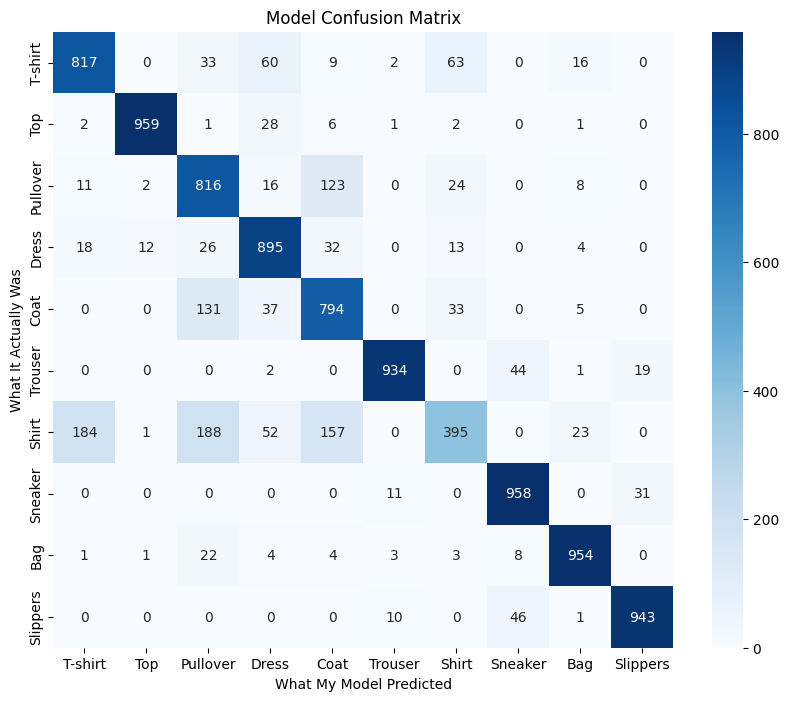

In [16]:
# I'm using a heatmap to make the confusion matrix look nice and easy to read.
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('What My Model Predicted')
plt.ylabel('What It Actually Was')
plt.title('Model Confusion Matrix')
plt.show()

In [17]:
# The classification report gives me precision, recall, and f1-score for each class.
print("\nHere's a detailed breakdown of my model's performance:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Here's a detailed breakdown of my model's performance:
              precision    recall  f1-score   support

     T-shirt       0.79      0.82      0.80      1000
         Top       0.98      0.96      0.97      1000
    Pullover       0.67      0.82      0.74      1000
       Dress       0.82      0.90      0.85      1000
        Coat       0.71      0.79      0.75      1000
     Trouser       0.97      0.93      0.95      1000
       Shirt       0.74      0.40      0.52      1000
     Sneaker       0.91      0.96      0.93      1000
         Bag       0.94      0.95      0.95      1000
    Slippers       0.95      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000

